In [18]:
dstype = 'cnews' 
mname = 'debertaV3'

In [19]:
 
modelpath = 'microsoft/deberta-v3-base'
# modelpath = "bert-base-uncased"


datapath = None
saveDIR = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"
print(saveDIR)
# %%

/home/bhairavi/om/om5/cnews/debertaV3_cnews


In [20]:


# %%
# %%
 
import os
import torch  

torch.cuda.empty_cache() 

import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 

 


# %%
 


In [34]:
df = pd.read_csv('/home/bhairavi/om/om5/cnews/cryptonews.csv')



 
 
 
 


In [35]:

# %%

# %%
df.sample(5)


# %%


,date,sentiment,source,subject,text,title,url
11784,2023-04-22 10:52:00,"{'class': 'positive', 'polarity': 0.35, 'subje...",CryptoPotato,bitcoin,The controversial model sees bitcoin more than...,This Will Be Bitcoin’s Price During the Next H...,https://cryptopotato.com/this-will-be-bitcoins...
16508,2022-12-30 11:54:44,"{'class': 'positive', 'polarity': 0.22, 'subje...",CoinTelegraph,ethereum,ETH price bulls struggle as futures remain tra...,"Ethereum needs to defend $1,180 to sustain thi...",https://cointelegraph.com/news/ethereum-needs-...
22570,2022-07-28 11:21:20,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,altcoin,LDO has recently witnessed a growing bearish d...,Lido DAO: Ethereum's biggest 'Merge' staker so...,https://cointelegraph.com/news/lido-dao-ethere...
17491,2022-12-03 14:34:02,"{'class': 'positive', 'polarity': 0.03, 'subje...",CoinTelegraph,defi,Smart contacts capable of handling complex com...,The future of smart contract adoption for ente...,https://cointelegraph.com/news/the-future-of-s...
21982,2022-08-15 02:01:00,"{'class': 'positive', 'polarity': 0.15, 'subje...",CryptoPotato,altcoin,Monero executed a hard fork to be more secure ...,Monero Executes Hard Fork To Improve Security ...,https://cryptopotato.com/monero-executes-hard-...


In [36]:
df['text']  = df['text'] + df['title']

In [37]:
df['label'] = df['subject']

In [38]:
df.columns

Index(['date', 'sentiment', 'source', 'subject', 'text', 'title', 'url',
       'label'],
      dtype='object')

In [39]:


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%


6

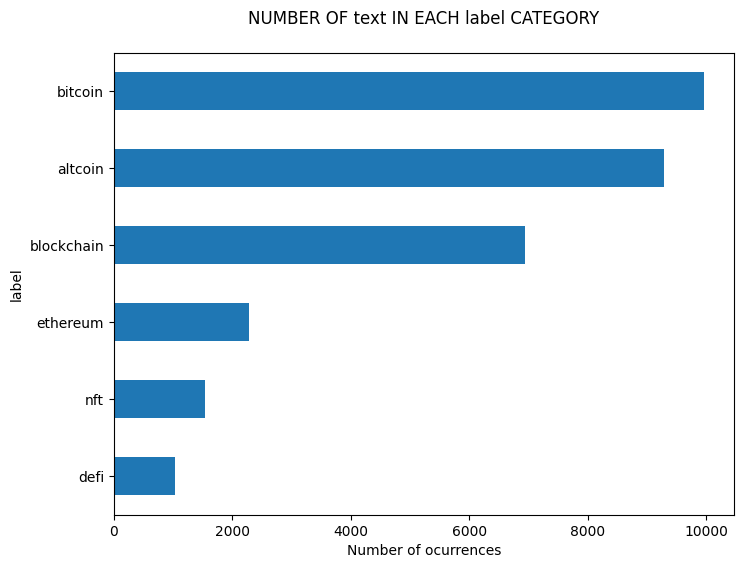

In [40]:



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


In [41]:
df = df[['text', 'target','label']]


In [42]:
df.columns

Index(['text', 'target', 'label'], dtype='object')

In [43]:
numlabel = df['target'].nunique()
numlabel


6

In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

/home/bhairavi/om/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/bhairavi/om/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [45]:
df['token_length'] = df['text'].apply(lambda x: len(x.split()))

# Calculate the maximum token length
max_length = df['token_length'].max()
# Calculate the next maximum token length
next_max_token_length = df['token_length'].nlargest(2).iloc[1] 


# Calculate the average token length
average_token_length = df['token_length'].mean()

# Display the results
print(f"Maximum token length: {max_length}")
print(f"Next maximum token length: {next_max_token_length}") 
print(f"Average token length: {average_token_length:.2f}")

# %%
min(df['token_length'])


Maximum token length: 102
Next maximum token length: 95
Average token length: 32.94


11

In [46]:

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)




Map: 100%|██████████| 1552/1552 [00:00<00:00, 4013.43 examples/s]


In [47]:


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 


# %%

# %%
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()

 
 



/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.636200,0.730531,0.758987,0.772809,0.759891
2,0.575500,0.633030,0.778956,0.786721,0.780014
3,0.282300,0.701260,0.777560,0.787370,0.776622


TrainOutput(global_step=9399, training_loss=0.6487288855532278, metrics={'train_runtime': 1796.5929, 'train_samples_per_second': 41.849, 'train_steps_per_second': 5.232, 'total_flos': 3941210880727344.0, 'train_loss': 0.6487288855532278, 'epoch': 3.0})

In [48]:
save_directory = saveDIR
 

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer (optional, but recommended)
tokenizer.save_pretrained(save_directory)

('/home/bhairavi/om/om5/cnews/debertaV3_cnews/tokenizer_config.json',
 '/home/bhairavi/om/om5/cnews/debertaV3_cnews/special_tokens_map.json',
 '/home/bhairavi/om/om5/cnews/debertaV3_cnews/spm.model',
 '/home/bhairavi/om/om5/cnews/debertaV3_cnews/added_tokens.json',
 '/home/bhairavi/om/om5/cnews/debertaV3_cnews/tokenizer.json')

In [49]:

# %%
from colorama import Fore, Style


# %% [markdown]
# eval dataset performance so that keywords_classes can be fixed

# %%
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)
print(Fore.CYAN,"keywords class evaluation detection RESULTS")
print(report)


# %% [markdown]
# skyline

# %%


 keywords class evaluation detection RESULTS
              precision    recall  f1-score   support

     altcoin     0.8680    0.8404    0.8540      1322
  blockchain     0.8776    0.8276    0.8519      1421
    ethereum     0.6110    0.7646    0.6792       990
     bitcoin     0.5161    0.2162    0.3048       148
         nft     0.7360    0.6883    0.7113       324
        defi     0.7588    0.6927    0.7242       218

    accuracy                         0.7800      4423
   macro avg     0.7279    0.6716    0.6876      4423
weighted avg     0.7867    0.7800    0.7790      4423



In [50]:


# %%
print(Fore.RED +"TEST DATA IS OUR SKYLINE RESULT")
 
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)

print(report)


TEST DATA IS OUR SKYLINE RESULT


              precision    recall  f1-score   support

     altcoin     0.8810    0.8297    0.8546       464
  blockchain     0.8866    0.8474    0.8665       498
    ethereum     0.6152    0.7925    0.6927       347
     bitcoin     0.4000    0.1923    0.2597        52
         nft     0.6875    0.5789    0.6286       114
        defi     0.6620    0.6104    0.6351        77

    accuracy                         0.7764      1552
   macro avg     0.6887    0.6419    0.6562      1552
weighted avg     0.7822    0.7764    0.7748      1552

